# SNN with hierarchy of Time constant
---
This notebook is mainly for developing the code that will be rewritten in python files\\

The idea is to explore what role a hierarchy of time scales have in temporal processing, especially when dealing with multi-time-scale inputs.\\

Prior literature shows the importance of heterogeneity of time scales in SNNs, mainly showing that diversity of time-scales are beneficial.
- https://www.nature.com/articles/s41467-021-26022-3
- https://www.nature.com/articles/s41467-023-44614-z

However, an interpretation of the role of the hierarchy of time constant is still missing.

The assumption is that when treating a temporal sequence sempled at a certain period $\tau_{sampling}$ and with a total duration $\Tau$, there can be an optimal sequence of filters $F_i(\tau_i)$ that process the input sequence. For each of the filters $\tau_{i+1} > \tau_i$, where the subscript indicates the order of the filter. More simply, there is a hierarchy of time-scales - from fast to slow - that leads to an optimal processing of the input sequence.

In [1]:
import jax
import jax.numpy as jnp
from jax.example_libraries import optimizers

import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import lognorm, norm
from sklearn.model_selection import train_test_split
import time
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import random_split
import random

import urllib.request
import gzip, shutil
import hashlib
import h5py
from six.moves.urllib.error import HTTPError
from six.moves.urllib.error import URLError
from six.moves.urllib.request import urlretrieve

from jax import vmap, pmap, jit, value_and_grad, local_device_count
from jax.example_libraries import optimizers
from jax.lax import scan, cond
import pickle

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".75" # needed because network is huge
os.environ["CUDA_VISIBLE_DEVICES"]="0"
np.set_printoptions(threshold=100000000)
jax.devices()

I0000 00:00:1709541961.131601       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


[CpuDevice(id=0)]

## Parameters of the SNN model
---

In [2]:
class SimArgs:
    def __init__(self):
        # archi
        self.n_in = 256
        self.n_out = 20
        self.n_layers = 3
        self.n_hid = 128
        # weight
        self.w_scale = 0.3
        self.pos_w = False # use only positive weights at initizialization
        self.noise_sd = 0 # [0.05, 0.1, 0.15, 0.2]
        # data
        self.nb_rep = 1
        self.nb_steps = 200 #int( np.round( self.time_max/self.timestep, 0 ) )
        self.time_max = 1.4 # second
        self.timestep = self.time_max/self.nb_steps # 0.014 #0.005 # second, 280 timesteps
        self.pert_proba = None
        self.truncation = False # to use only 150 of 280 timesteps 
        # neuron model
        self.tau_start = 4*self.timestep # second
        self.tau_end   = self.time_max/4 # second
        self.tau_mem = 40e-3
        self.tau_out = 1e-3
        self.recurrent = False
        self.distrib_tau = True
        self.hierarchy_tau = True
        self.train_alpha = True
        self.normalizer = 'layer'
        self.norm_bias_init = 0.2
        self.v_rest = 0 
        self.v_thr = 1
        self.v_reset = 0
        self.surrogate_fn = 'box'
        # training
        self.lr = 0.01
        self.nb_epochs = 5
        self.grad_clip = 1000
        self.batch_size = 128
        self.seed = 42
        self.lr_config = 2 
        self.lr_decay = 0.5
        self.lr_decay_every = 25
        self.l2_lambda = 1e-5
        self.freq_lambda = 1e-7
        self.target_fr = 12.
        self.dropout_rate = 0.1

args = SimArgs()

## Download and Import the SHD dataset
---

In [3]:
from utils_dataset import *
train_loader_custom_collate, val_loader_custom_collate, test_loader_custom_collate = get_dataloader( args=args, verbose=True )

Train DL size: 8156, Validation DL size: 1632, Test DL size: 2264


## Neuron Model
---
We'll use Leaky-Integrate-and-Fire neurons for the Hidden layers, Leaky-Integrator neurons for the output.

We also define some additional functions to: Introduce Noise in Weights and Membrane voltage, Introduce the Surrogate Gradient function.

In [4]:
### Noise function
@jax.custom_jvp
def add_noise(w, key, noise_std):
    ''' Adds noise only for inference '''
    noisy_w = jnp.where(w != 0.0,
                        w + jax.random.normal(key, w.shape) * jnp.max(jnp.abs(w)) * noise_std,
                        w)
    return noisy_w

@add_noise.defjvp
def add_noise_jvp(primals, tangents):
    weight, key, noise_std = primals
    x_dot, y_dot, z_dot = tangents
    primal_out = add_noise(weight, key, noise_std)
    tangent_out = x_dot
    return primal_out, tangent_out


### Surrogate Gradient function
@jax.custom_jvp
def spiking_fn(x, thr):
    """ Thresholding function for spiking neurons. """
    return (x > thr).astype(jnp.float32)

if args.surrogate_fn == 'box':
    @spiking_fn.defjvp
    def spiking_jpv(primals, tangents):
        """ Surrogate gradient function for thresholding. """
        x, thr = primals
        x_dot, y_dot = tangents
        primal_out = spiking_fn(x, thr)
        # tangent_out = x_dot / (10 * jnp.absolute(x - thr) + 1)**2
        tangent_out = x_dot * ( jnp.absolute(x-thr)<0.5 ).astype(int)
        return primal_out, tangent_out
else: 
    @spiking_fn.defjvp
    def spiking_jpv(primals, tangents):
        """ Surrogate gradient function for thresholding. """
        x, thr = primals
        x_dot, y_dot = tangents
        primal_out = spiking_fn(x, thr)
        tangent_out = x_dot / (10 * jnp.absolute(x - thr) + 1)**2
        return primal_out, tangent_out

In [9]:
def params_initializer( key, args ):
    """ Initialize parameters. """
    key_hid = jax.random.split(key, args.n_layers); key=key_hid[0]; key_hid=key_hid[1:]

    # Initializing the weights, weight masks and time constant (alpha factors)
    w_scale = reshape_weight_scale_factor(args.w_scale, args.n_layers, args.recurrent)
    net_params, net_states = [], []
    for l in range(args.n_layers):

        if l == args.n_layers-1:
            n_pre = args.n_hid; n_post = args.n_out
            # same time-constant for output neurons
            tau_l = args.tau_out #args.tau_start + (l/args.n_layers)*( args.tau_end-args.tau_start )
            alpha_l = jnp.exp(-args.timestep/tau_l)

        else:
            if l == 0: n_pre = args.n_in; n_post = args.n_hid
            else: n_pre = args.n_hid; n_post = args.n_hid

            # partition of the time constants in the different layers
            if args.hierarchy_tau: tau_layer = args.tau_start + (l/ (args.n_layers-1))*( args.tau_end-args.tau_start )
            else: tau_layer = args.tau_mem
            if args.distrib_tau:
                # tau_l = jax.random.uniform(key_hid[l], [args.n_hid], minval=0.5*tau_layer, maxval=1.5*tau_layer  )
                tau_l = jax.random.normal(key_hid[l], [args.n_hid]) * 0.1 * tau_layer + tau_layer
            else:
                tau_l = tau_layer
            alpha_l = jnp.exp(-args.timestep/tau_l)

        # initializing the hidden weights with a normal distribution
        if not args.recurrent: w_scale_ff = w_scale[l]
        else: w_scale_ff = w_scale[l][0]
        weight_l = jax.random.normal(key_hid[l], [n_pre, n_post]) * w_scale_ff
        weight_mask_l = 1 # jax.random.uniform(key_hid[l], [n_pre, n_post]) < (1/args.n_layers)
        if args.recurrent and l!=args.n_layers-1 : 
            weight_rec_l = jax.random.normal(key_hid[l], [n_post, n_post]) * w_scale[l][1]
            weight_l = [weight_l, weight_rec_l]
            weight_mask__rec_l = 1 # jax.random.uniform(key_hid[l], [n_post, n_post]) < (1/args.n_layers)
            weight_mask_l = [weight_mask_l, weight_mask__rec_l]
        if args.normalizer is not None:
            scale_norm = jnp.ones( (n_post) ) #jax.random.normal(key_hid[l], [n_post]) * (1/args.w_scale)
            bias_norm = jnp.zeros( (n_post) ) + args.norm_bias_init #jax.random.normal(key_hid[l], [n_post]) * (1/args.w_scale)
            weight_l = [weight_l, scale_norm, bias_norm]

        # the initialization of the membrane voltage
        v_mems = np.zeros( (n_post) )
        out_spikes = np.zeros( (n_post) )

        # building the parameters for each layer
        net_params.append( [weight_l, alpha_l] )
        net_states.append( [weight_mask_l, tau_l, v_mems, out_spikes, args.v_thr, args.noise_sd] )

    return net_params, net_states

def reshape_weight_scale_factor( w_scale, n_layers, recurrent = False ):
    w_scale = np.array(w_scale)
    if recurrent: 
        w_scale_out = np.zeros( (n_layers, 2) )
        if w_scale.shape == (n_layers, 2): w_scale_out = w_scale
        elif w_scale.shape == (n_layers,): w_scale_out = np.stack( [w_scale, w_scale] ).reshape(2, n_layers).T
        elif w_scale.shape == (n_layers*2,): w_scale_out = np.stack( [w_scale] ).reshape(2, n_layers).T
        elif w_scale.shape == (2,): w_scale_out = np.array(list(w_scale)*n_layers).reshape(n_layers, 2)
        elif w_scale.shape == (1,): w_scale_out = np.array(list(w_scale)*n_layers*2).reshape(n_layers, 2)
        else: w_scale_out = np.array( [ np.mean(w_scale) ]*n_layers*2).reshape(n_layers, 2)
    else:
        w_scale_out = np.zeros( (n_layers) )
        if w_scale.shape == (n_layers, ): w_scale_out = w_scale
        elif w_scale.shape == (1,): w_scale_out = np.array(list(w_scale)*n_layers).reshape(n_layers)
        else: w_scale_out = np.array( [ np.mean(w_scale) ]*n_layers).reshape(n_layers)
    return w_scale_out

In [5]:
# Normalization Layers
from typing import (Any, Callable, Iterable, Optional, Tuple, Union)

PRNGKey = Any
Array = Any
Shape = Tuple[int, ...]
Dtype = Any  # this could be a real type?

Axes = Union[int, Iterable[int]]

def _canonicalize_axes(rank: int, axes: Axes) -> Tuple[int, ...]:
    """Returns a tuple of deduplicated, sorted, and positive axes."""
    if not isinstance(axes, Iterable):
        axes = (axes,)
    return tuple(set([rank + axis if axis < 0 else axis for axis in axes]))


def _abs_sq(x):
    """Computes the elementwise square of the absolute value |x|^2."""
    if jnp.iscomplexobj(x):
        return jax.lax.square(jax.lax.real(x)) + jax.lax.square(jax.lax.imag(x))
    else:
        return jax.lax.square(x)

def _compute_stats(x: Array, axes: Axes,
                   dtype: Optional[Dtype],
                   axis_name: Optional[str] = None,
                   axis_index_groups: Any = None):
    """Computes mean and variance statistics.
    Returns:
      A pair ``(mean, var)``.
    """
    if dtype is None:
      dtype = jnp.result_type(x)
    # promote x to at least float32, this avoids half precision computation
    # but preserves double or complex floating points
    dtype = jnp.promote_types(dtype, jnp.float32)
    x = jnp.asarray(x, dtype)

    mean = jnp.mean(x, axes)
    mean2 = jnp.mean(_abs_sq(x), axes)
    if axis_name is not None:
      concatenated_mean = jnp.concatenate([mean, mean2])
      mean, mean2 = jnp.split(
          jax.lax.pmean(
              concatenated_mean,
              axis_name=axis_name,
              axis_index_groups=axis_index_groups), 2)
    # mean2 - _abs_sq(mean) is not guaranteed to be non-negative due
    # to floating point round-off errors.
    var = jnp.maximum(0., mean2 - _abs_sq(mean))
    return mean, var


def _normalize(x: Array, mean: Array, var: Array,
               reduction_axes: Axes, feature_axes: Axes,
               dtype: Dtype, param_dtype: Dtype,
               epsilon: float,
               bias: Array,
               scale: Array):
    """"Normalizes the input of a normalization layer and optionally applies a learned scale and bias.

    Arguments:
    mdl: Module to apply the normalization in (normalization params will reside
        in this module).
    x: The input.
    mean: Mean to use for normalization.
    var: Variance to use for normalization.
    reduction_axes: The axes in ``x`` to reduce.
    feature_axes: Axes containing features. A separate bias and scale is learned
        for each specified feature.
    dtype: The dtype of the result (default: infer from input and params).
    param_dtype: The dtype of the parameters.
    epsilon: Normalization epsilon.
    use_bias: If true, add a bias term to the output.
    use_scale: If true, scale the output.
    bias_init: Initialization function for the bias term.
    scale_init: Initialization function for the scaling function.

    Returns:
    The normalized input.
    """
    reduction_axes = _canonicalize_axes(x.ndim, reduction_axes)
    feature_axes = _canonicalize_axes(x.ndim, feature_axes)
    stats_shape = list(x.shape)
    for axis in reduction_axes:
        stats_shape[axis] = 1
    mean = mean.reshape(stats_shape)
    var = var.reshape(stats_shape)
    feature_shape = [1] * x.ndim
    reduced_feature_shape = []
    for ax in feature_axes:
        feature_shape[ax] = x.shape[ax]
        reduced_feature_shape.append(x.shape[ax])
    y = x - mean
    mul = jax.lax.rsqrt(var + epsilon)
    args = [x]
    # scale = mdl.param('scale', scale_init, reduced_feature_shape,
    #                     param_dtype).reshape(feature_shape)
    mul *= scale
    args.append(scale)
    y *= mul
    # bias = mdl.param('bias', bias_init, reduced_feature_shape,
    #                     param_dtype).reshape(feature_shape)
    y += bias
    args.append(bias)
    #   dtype = canonicalize_dtype(*args, dtype=dtype)
    return jnp.asarray(y)


def LayerNorm( x, epsilon: float = 1e-6, dtype: Optional[Dtype] = None, param_dtype: Dtype = jnp.float32, use_bias: bool = True,use_scale: bool = True,
                bias: Array = jax.nn.initializers.zeros, scale: Array = jax.nn.initializers.ones, reduction_axes: Axes = -1,feature_axes: Axes = -1,
                axis_name: Optional[str] = None, axis_index_groups: Any = None ):
    """Layer normalization (look at the _normalization function to see the role of the arguments) """
    mean, var = _compute_stats(x, reduction_axes, dtype, axis_name, axis_index_groups)
    return _normalize( x, mean, var, reduction_axes, feature_axes, dtype, param_dtype, epsilon, bias, scale)


def BatchNorm( x, axis: int=-1, momentum:float=0.05, epsilon: float = 1e-5, dtype: Optional[Dtype] = None,
                param_dtype: Dtype = jnp.float32,
                bias: Array = jax.nn.initializers.zeros, scale: Array = jax.nn.initializers.zeros,
                axis_name: Optional[str] = None, axis_index_groups: Any = None,
                ra_mean: Array = None, ra_var: Array = None ):
    """BatchNorm Module"""

    feature_axes = _canonicalize_axes(x.ndim, axis)
    reduction_axes = tuple(i for i in range(x.ndim) if i not in feature_axes)
    feature_shape = [x.shape[ax] for ax in feature_axes]

    if (ra_mean is not None) and (ra_var is not None):
      mean, var = ra_mean.value, ra_var.value
    else:
      mean, var = _compute_stats( x, reduction_axes, dtype=dtype, axis_name=axis_name, axis_index_groups=axis_index_groups)

      if (ra_mean is not None) and (ra_var is not None) :
        ra_mean = momentum * ra_mean + (1 - momentum) * mean
        ra_var = momentum * ra_var + (1 - momentum) * var

    return _normalize( x, mean, var, reduction_axes, feature_axes,
                        dtype, param_dtype, epsilon, bias, scale)

In [8]:
key = jax.random.PRNGKey(seed=args.seed)
x = jax.random.normal( key, [2,4], dtype=jnp.float32 ) + 10
mean, var = _compute_stats(x, axes=-1, dtype=jnp.float32)
print( mean, var )

y = _normalize(x, mean, var,
               reduction_axes = -1, feature_axes = -1,
               dtype= jnp.float32, param_dtype = jnp.float32,
               epsilon = 1e-6,
               bias = jnp.zeros( (x.shape[-1]) ),
               scale = jnp.ones( (x.shape[-1]) ))
print( jnp.mean(y, axis=-1), jnp.var(y, axis=-1) )

ynorm = LayerNorm( x, bias = jnp.zeros( (x.shape[-1]) ),
               scale = jnp.ones( (x.shape[-1]) ) )
print( jnp.mean(ynorm, axis=-1), jnp.var(ynorm, axis=-1) )

yBnorm = BatchNorm( x, bias = jnp.zeros( (x.shape[-1]) ),
               scale = jnp.ones( (x.shape[-1]) ) )
print( jnp.mean(yBnorm), jnp.var(yBnorm) )

[9.852972 8.918796] [0.27605438 1.6597519 ]
[8.9406967e-07 1.7881393e-07] [0.99994993 0.999993  ]
[8.9406967e-07 1.7881393e-07] [0.99994993 0.999993  ]
1.3411045e-07 0.9998141


In [6]:
# Leaky Integrate and Fire layer
def lif_forward(net_params, net_states, input_spikes):
    ''' Forward function for the Leaky-Integrate and Fire neuron layer, adopted here for the hidden layers. '''

    # state: the parameters (weights) and the state of the neurons (spikes, inputs and membrane, ecc..)
    w, alpha = net_params; w_mask, tau, V_mem, out_spikes, v_thr, noise_sd = net_states

    # we evolve the state of the neuron according to the LIF formula, Euler approximation
    I_in = jnp.matmul(input_spikes, w*w_mask)
    # V_mem = (alpha) * (V_mem) + (1-alpha) * I_in - out_spikes*v_thr
    V_mem = alpha * V_mem + I_in - out_spikes*v_thr

    out_spikes = spiking_fn( V_mem, v_thr )
    
    return [w, alpha], [w_mask, tau, V_mem, out_spikes, v_thr, noise_sd]

def lif_forward(net_params, net_states, input_spikes, norm=LayerNorm):
    ''' Forward function for the Leaky-Integrate and Fire neuron layer, adopted here for the hidden layers. '''

    # state: the parameters (weights) and the state of the neurons (spikes, inputs and membrane, ecc..)
    w, alpha = net_params; w_mask, tau, V_mem, out_spikes, v_thr, noise_sd = net_states
    if len(w) == 3: # it means that we'll do normalization
        weight, scale, bias = w
    else: weight = w

    # we evolve the state of the neuron according to the LIF formula, Euler approximation
    I_in = jnp.matmul(input_spikes, weight*w_mask)
    # normalize inputs
    if len(w) == 3: I_in_norm = norm( I_in, bias = bias, scale = scale )
    else: I_in_norm = I_in #norm( I_in, bias = jnp.zeros( (I_in.shape[-1]) ), scale = jnp.ones( (I_in.shape[-1]) ) )
    # V_mem = (alpha) * (V_mem) + (1-alpha) * I_in - out_spikes*v_thr
    V_mem = alpha * V_mem + I_in_norm - out_spikes*v_thr

    out_spikes = spiking_fn( V_mem, v_thr )
    return [w, alpha], [w_mask, tau, V_mem, out_spikes, v_thr, noise_sd]

# Leaky Integrate and Fire layer, Recurrent
def lif_recurrent(net_params, net_states, input_spikes):
    ''' Forward function for the Leaky-Integrate and Fire neuron layer, adopted here for the hidden layers. '''

    # state: the parameters (weights) and the state of the neurons (spikes, inputs and membrane, ecc..)
    w, alpha = net_params; w_mask, tau, V_mem, out_spikes, v_thr, noise_sd = net_states
    win_mask, wrec_mask = w_mask
    if len(w) == 3: # it means that we'll do normalization
        weight, scale, bias = w
    else: weight = w
    win, wrec = weight

    # we evolve the state of the neuron according to the LIF formula, Euler approximation
    I_in = jnp.matmul(input_spikes, win*win_mask)
    I_rec = jnp.matmul(out_spikes, wrec*wrec_mask)
    # Normalization
    if len(w) == 3: I_in_norm = norm( I_in+I_rec, bias = bias, scale = scale )
    else: I_in_norm = I_in + I_rec #norm( I_in, bias = jnp.zeros( (I_in.shape[-1]) ), scale = jnp.ones( (I_in.shape[-1]) ) )
    # V_mem = (alpha) * (V_mem) + (1-alpha) * I_in - out_spikes*v_thr
    V_mem = alpha * V_mem + I_in_norm - out_spikes*v_thr
    out_spikes = spiking_fn( V_mem, v_thr )
    
    return [w, alpha], [w_mask, tau, V_mem, out_spikes, v_thr, noise_sd]

# Leaky Integrator (output layer)
def li_output(net_params, net_states, input_spikes):
    ''' Forward function for the Leaky-Integrator neuron layer, adopted here for the output layers. '''

    # state: the parameters (weights) and the state of the neurons (inputs and membrane)
    w, alpha = net_params; w_mask, tau, V_mem, out_spikes, v_thr, noise_sd = net_states

    # we evolve the state of the neuron according to the LI formula, Euler approximation
    I_in = jnp.matmul(input_spikes, w*w_mask)
    # V_mem = (alpha) * (V_mem) + (1-alpha) * I_in
    V_mem = (alpha) * (V_mem) + I_in
    
    return [w, alpha], [w_mask, tau, V_mem, out_spikes, v_thr, noise_sd]

# Leaky Integrator (output layer)
def li_output(net_params, net_states, input_spikes, norm=LayerNorm):
    ''' Forward function for the Leaky-Integrator neuron layer, adopted here for the output layers. '''

    # state: the parameters (weights) and the state of the neurons (inputs and membrane)
    w, alpha = net_params; w_mask, tau, V_mem, out_spikes, v_thr, noise_sd = net_states
    if len(w) == 3:
        # it means that we'll do normalization
        weight, scale, bias = w
    else: weight = w

    # we evolve the state of the neuron according to the LI formula, Euler approximation
    I_in = jnp.matmul(input_spikes, weight*w_mask)
    if len(w) == 3: I_in_norm = norm( I_in, bias = bias, scale = scale )
    else: I_in_norm = I_in #norm( I_in, bias = jnp.zeros( (I_in.shape[-1]) ), scale = jnp.ones( (I_in.shape[-1]) ) )
    # V_mem = (alpha) * (V_mem) + (1-alpha) * I_in
    V_mem = (alpha) * (V_mem) + I_in_norm
    
    return [w, alpha], [w_mask, tau, V_mem, out_spikes, v_thr, noise_sd]

# custom dropout function
def dropout( rng, inputs, rate:float = 0.1, deterministic = True, broadcast_dims = () ):
    # if (rate == 0.) or deterministic:
    #   return inputs
    keep_prob = 1. - rate
    broadcast_shape = list(inputs.shape)
    for dim in broadcast_dims:
      broadcast_shape[dim] = 1
    mask = jax.random.bernoulli(rng, p=keep_prob, shape=broadcast_shape)
    mask = jnp.broadcast_to(mask, inputs.shape)
    return jax.lax.select(mask, inputs / keep_prob, jnp.zeros_like(inputs))

# the SNN network
def hsnn_step( args_in, input_spikes):
    '''The Hierarchical time-constant SNN (hSNN). Made of n_layers layers.'''
    net_params, net_states, key, dropout_rate = args_in
    n_layers = len(net_params)
    for l in range(0, n_layers-1):
        # Hidden layer takes inputs from their previous layer
        if l == 0: input_layer = input_spikes  # First layer takes inputs from "input spikes"
        else: input_layer = net_states[l-1][3] # net_params[l-1][3] : output spikes from previous layer
        net_params[l], net_states[l] = lif_forward( net_params[l], net_states[l], input_layer )
        # dropout
        key, key_dropout = jax.random.split(key, 2)
        net_states[l][3] = dropout( key_dropout, net_states[l][3], rate=dropout_rate, deterministic=False )
    # Output layer is a leaky integrator (LI)
    net_params[-1], net_states[-1] = li_output( net_params[-1], net_states[-1], net_states[-2][3] )

    return [net_params, net_states, key, dropout_rate], net_states # net_params[-1][4] : output leaky membrane voltage

# the SNN network
def hrsnn_step( args_in, input_spikes):
    '''The Hierarchical time-constant SNN (hSNN). Made of n_layers layers.'''
    net_params, net_states, key, dropout_rate = args_in
    n_layers = len(net_params)
    for l in range(0, n_layers-1):
        # Hidden layer takes inputs from their previous layer
        if l == 0: input_layer = input_spikes  # First layer takes inputs from "input spikes"
        else: input_layer = net_states[l-1][3] # net_params[l-1][3] : output spikes from previous layer
        net_params[l], net_states[l] = lif_recurrent( net_params[l], net_states[l], input_layer ) 
        # dropout
        key, key_dropout = jax.random.split(key, 2)
        net_states[l][3] = dropout( key_dropout, net_states[l][3], rate=dropout_rate, deterministic=False )
    # Output layer is a leaky integrator (LI)
    net_params[-1], net_states[-1] = li_output( net_params[-1], net_states[-1], net_states[-2][3] )

    return [net_params, net_states, key, dropout_rate], net_states # net_params[-1][4] : output leaky membrane voltage

def decoder_sum( out_v_mem ):
    ''' Decodes the output as the sum of the membrane voltage over time '''
    # out_v_mem dims: [batch, time_steps, out_dim]
    return jax.nn.softmax( jnp.mean( out_v_mem, axis=1 ), axis=-1 )

def decoder_cum( out_v_mem ):
    ''' Decodes the output as the sum of the "softmaxed" membrane voltage over time '''
    # out_v_mem dims: [batch, time_steps, out_dim]
    return jnp.mean( jax.nn.softmax( out_v_mem, axis=-1 ), axis=1)

# def decoder_vmax( out_v_mem ):
#     return jax.nn.softmax( jnp.max( out_v_mem[:,10:], axis=1 ), axis=-1 )
def decoder_vmax( out_v_mem ):
    ''' Decodes the output as the maximum of the membrane voltage over time '''
    # out_v_mem dims: [batch, time_steps, out_dim]
    return jax.nn.softmax( jnp.max( out_v_mem, axis=1 ), axis=-1 )

def decoder_vlast( out_v_mem ):
    ''' Decodes the output as the last value of the membrane voltage over time '''
    # out_v_mem dims: [batch, time_steps, out_dim]
    return jax.nn.softmax( out_v_mem[:,-1], axis=-1 )

In [18]:
### try and do a forward pass
key = jax.random.PRNGKey(seed=args.seed)
# load data
x_train, Y = next(iter( train_loader_custom_collate ))
x_test, Y_test = next(iter( train_loader_custom_collate ))
print('Input shape: train '+ str(x_train.shape) + ' - test '+ str(x_test.shape) )

# initialize parameters
dropout_rate = 0.0
args.distrib_tau = True
args.hierarchy_tau = True
args.recurrent = True
args.normalizer = 'batch' #'layer'
args.n_layers = 2
if args.recurrent:
    layer = lif_recurrent
    model = hrsnn_step
else:
    layer = lif_forward
    model = hsnn_step
norm = BatchNorm
args.w_scale = [0.3] 
net_params, net_states = params_initializer( key, args )

# forward pass: LIF layer
net_params[0], net_states[0] = layer( net_params[0], net_states[0], x_train[0,50] )
# printing the size of alpha
for n in range(len(net_params)):
    print(f'Alpha, layer {n}, size: {net_params[n][1].shape}')

# forward pass: network
args_out = model( [net_params, net_states, key, dropout_rate], x_train[0,50] )
print( len(args_out) )

# dropout
y = dropout( key, jnp.ones( (2, 3, 4) ), rate=0.8, deterministic=False )
print('\n Dropout test'+ str(y))


Input shape: train (128, 200, 256) - test (128, 200, 256)
Alpha, layer 0, size: (128,)
Alpha, layer 1, size: ()
2

 Dropout test[[[0. 0. 0. 5.]
  [5. 0. 5. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [5. 0. 0. 0.]
  [0. 5. 0. 0.]]]


In [21]:
len( net_params[0][0] )

3

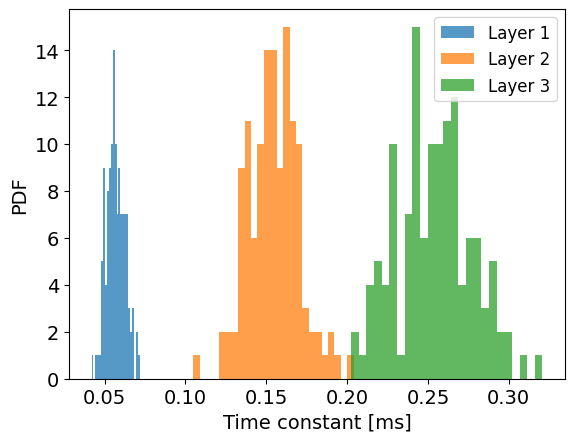

In [8]:
fig, ax = plt.subplots( )
for n in range(len(net_params)):
    if len(net_params[n][1].shape)>0:
        _ = ax.hist(-args.timestep/ np.log(net_params[n][1]), 25, alpha=0.75, label='Layer '+str(n+1))
ax.set_xlabel( 'Time constant [ms]', size=14 )
ax.set_ylabel( 'PDF', size=14 )
ax.tick_params( labelsize=14 )
ax.legend( prop={'size':12} )

# Training Loop
---

In [20]:
@jit
def predict(args_in, X):
    """ Scans over time and return predictions. """
    # net_params, net_states, key, dropout_rate = args_in
    _, net_states_hist = scan(model, args_in, X, length=args.nb_steps)
    return net_states_hist
# vmap the forward of the model
v_predict = vmap(predict, in_axes=(None, 0))

def one_hot(x, n_class):
    return jnp.array(x[:, None] == jnp.arange(n_class), dtype=jnp.float32)

def loss(key, net_params, net_states, X, Y, epoch, dropout_rate=0.):
    """ Calculates CE loss after predictions. """

    # we might want to add noise in the forward pass --> memristor-aware-training
    # weight = [net_params[i][0] for i in range( len(net_params) )]
    # weight = cond(
    #     epoch >= noise_start_step, 
    #     lambda weight, key : add_noise(weight, key, noise_std),
    #     lambda weight, key : weight,
    #     weight, key
    # )
    # forward pass
    net_states_hist = v_predict( [net_params, net_states, key, dropout_rate], X)
    out_v_mem = net_states_hist[-1][2]
    Yhat = decoder_sum( out_v_mem )
    # compute the loss and correct examples
    num_correct = jnp.sum(jnp.equal(jnp.argmax(Yhat, 1), jnp.argmax(Y, 1)))
    # cross entropy loss
    # loss_ce = -jnp.mean( jnp.log( jnp.sum( Yhat * Y, axis=-1, dtype=jnp.float32) + 1e-8 ) )
    loss_ce = -jnp.mean( jnp.sum(Y * jnp.log(Yhat), axis=-1) )
    # L2 norm
    loss_l2 = optimizers.l2_norm( net_params ) * args.l2_lambda
    # firing rate loss
    avg_spikes_neuron = jnp.mean( jnp.stack( [ jnp.mean( jnp.sum( net_states_hist[l][3], axis=1 ), axis=(0,-1) ) for l in range( len(net_params)-1 )] ) )
    loss_fr = args.freq_lambda * (args.target_fr - avg_spikes_neuron)**2
    ################# ----> Do I need the spiking frequency regularizer?
    loss_total = loss_ce + loss_l2 + loss_fr
    loss_values = [num_correct, loss_ce]
    return loss_total, loss_values

# initialize parameters
dropout_rate = 0.0
args.distrib_tau = True
args.hierarchy_tau = False
args.recurrent = True
args.normalizer = 'batch' #'layer'
if args.recurrent:
    layer = lif_recurrent
    model = hrsnn_step
else:
    layer = lif_forward
    model = hsnn_step
norm = BatchNorm
args.n_layers = 4
net_params, net_states = params_initializer( key, args )

dropout_rate = 0.0
# testing the training function
args_ins = [net_params, net_states, key, dropout_rate]
args_out = scan(model, args_ins, x_train[0], length=args.nb_steps)
[net_params_hist, net_states_hist] = args_out

net_states_hist = v_predict( [net_params, net_states, key, dropout_rate], x_train )
out_v_mem = net_states_hist[-1][2]

# decoder
Yhat = jax.nn.softmax( jnp.mean( out_v_mem, axis=1 ), axis=-1 )
Yhat_vmax = jax.nn.softmax( jnp.max( out_v_mem, axis=1 ), axis=-1 )
Yhat_cum = jnp.mean( jax.nn.softmax( out_v_mem, axis=-1 ), axis=1)
print( Yhat_cum.shape )

# loss
loss_total, loss_values = loss(key, net_params, net_states, x_train, one_hot(Y, 20), 0)

# values and gradients
value, grads = value_and_grad(loss, has_aux=True, argnums=(1))(key, net_params, net_states, x_train, one_hot(Y,20), 0, dropout_rate=0.1)

(128, 20)


In [54]:
jnp.log( decoder_sum( out_v_mem )[6] +1e-12)

Array([-27.631021, -27.631021, -27.631021, -27.631021, -27.631021,
       -27.631006, -27.631021, -27.631021,   0.      , -27.631021,
       -27.630758, -27.631021, -27.631021, -27.631021, -27.630957,
       -27.631021, -27.63096 , -27.60068 , -27.631021, -27.631021],      dtype=float32)

In [7]:
def train_mosaic(key, n_batch, n_epochs, args, 
                 lr, train_dl, test_dl, val_dl,
                 model, param_initializer, decoder, 
                 noise_start_step, noise_std, dataset_name, verbose=True):
    
    key, key_model = jax.random.split(key, 2)

    @jit
    def predict(args_in, X):
        """ Scans over time and return predictions. """
        _, net_states_hist = scan(model, args_in, X, length=args.nb_steps)
        return net_states_hist
    # vmap the forward of the model
    v_predict = vmap(predict, in_axes=(None, 0))

    def loss(key, net_params, net_states, X, Y, epoch, dropout_rate=0.0):
        """ Calculates CE loss after predictions. """

        # we might want to add noise in the forward pass --> memristor-aware-training
        # weight = [net_params[i][0] for i in range( len(net_params) )]
        # weight = cond(
        #     epoch >= noise_start_step, 
        #     lambda weight, key : add_noise(weight, key, noise_std),
        #     lambda weight, key : weight,
        #     weight, key
        # )
        # forward pass
        net_states_hist = v_predict( [net_params, net_states, key, dropout_rate], X)
        out_v_mem = net_states_hist[-1][2]
        Yhat = decoder( out_v_mem )
        # compute the loss and correct examples
        num_correct = jnp.sum(jnp.equal(jnp.argmax(Yhat, 1), jnp.argmax(Y, 1)))
        # cross entropy loss
        # loss_ce = -jnp.mean( jnp.log( jnp.sum( Yhat * Y, axis=-1, dtype=jnp.float32) + 1e-8 ) )
        loss_ce = -jnp.mean( jnp.sum(Y * jnp.log(Yhat+1e-12), axis=-1) )
        # L2 norm
        loss_l2 = optimizers.l2_norm( net_params ) * args.l2_lambda
        # firing rate loss
        avg_spikes_neuron = jnp.mean( jnp.stack( [ jnp.mean( jnp.sum( net_states_hist[l][3], axis=1 ), axis=(0,-1) ) for l in range( len(net_params)-1 )] ) )
        loss_fr = args.freq_lambda * (args.target_fr - avg_spikes_neuron)**2
        ################# ----> Do I need the spiking frequency regularizer?
        loss_total = loss_ce + loss_l2 + loss_fr
        loss_values = [num_correct, loss_ce]
        return loss_total, loss_values
 
    @jit
    def update(key, epoch, net_states, X, Y, opt_state, dropout_rate=0.):
        train_params = get_params(opt_state)
        # forward pass with gradients
        value, grads = value_and_grad(loss, has_aux=True, argnums=(1))(key, train_params, net_states, X, Y, epoch, dropout_rate=dropout_rate)
        # possibly disable gradients on alpha and gradient clip
        # for g in range( len( grads )-1 ):
        #     if len(grads[g][0]) == 1:
        #         grads[g][0] = jnp.clip(grads[g][0], -args.grad_clip, args.grad_clip) # weight
        #     if len(grads[g][0]) == 2:
        #         for j in range( len(grads[g][0]) ):
        #             grads[g][0][j] = jnp.clip(grads[g][0][j], -args.grad_clip, args.grad_clip) # weight and recurrent
        #     grads[g][1] = jnp.clip(grads[g][1], -args.grad_clip, args.grad_clip) # alpha
        # grads[-1][0] = jnp.clip(grads[-1][0], -args.grad_clip, args.grad_clip) # weight
        # grads[-1][1] = jnp.clip(grads[-1][1], -args.grad_clip, args.grad_clip) # alpha
        return grads, opt_state, value

    def one_hot(x, n_class):
        return jnp.array(x[:, None] == jnp.arange(n_class), dtype=np.float32)

    def total_correct(net_params, net_states, X, Y):
        net_states_hist = v_predict( [net_params, net_states, key, 0.], X) # last value refers to the Dropout rate
        out_v_mem = net_states_hist[-1][2]
        Yhat = decoder( out_v_mem )
        acc = jnp.sum(jnp.equal(jnp.argmax(Yhat, 1), Y))
        return acc

    # LR decay
    if args.lr_decay_every < n_epochs:
        lr_decay = jnp.clip( args.lr_decay, 0, 1 )
        intervals = [i*args.lr_decay_every for i in range(int(n_epochs/args.lr_decay_every)-1)]
        lr_values = [lr*(lr_decay)**i for i in range(int(n_epochs/args.lr_decay_every))]
        pw_lr = optimizers.piecewise_constant(intervals, lr_values)
    else: pw_lr = optimizers.piecewise_constant([n_epochs], [lr, lr*jnp.clip( args.lr_decay, 1e-8, 1-1e-8 )])
    # define the optimizer
    opt_init, opt_update, get_params = optimizers.adam(step_size=pw_lr)
    # opt_init, opt_update, get_params = optimizers.sgd(step_size=pw_lr)
    # initialize the parameters (and states)
    net_params, net_states = param_initializer( key_model, args )
    opt_state = opt_init(net_params)

    # Training loop
    train_loss = []
    train_step = 0
    for epoch in range(n_epochs):
        t = time.time()
        acc = 0; count = 0
        for batch_idx, (x, y) in enumerate(train_dl):
            y = one_hot(y, args.n_out)
            key, _ = jax.random.split(key)
            grads, opt_state, (L, [tot_correct, _]) = update(key, epoch, net_states, x, y, opt_state, dropout_rate=args.dropout_rate)
            # possibly remove gradient from alpha
            if not args.train_alpha: 
                for g in range(len(grads)): grads[g][1] *= 0
            # weight update
            opt_state = opt_update(epoch, grads, opt_state)
            net_params = get_params(opt_state)
            # clip alpha between 0 and 1
            if args.train_alpha:
                for g in range(len(net_params)): net_params[g][1] = jnp.clip(net_params[g][1], 0, 1)
            # append stats
            train_loss.append(L)
            train_step += 1
            acc += tot_correct
            count += x.shape[0]
        
        # Training logs
        train_acc = 100*acc/count
        elapsed_time = time.time() - t
        if verbose: print(f'Epoch: [{epoch+1}/{n_epochs}] - Loss: {L:.5f} - '
              f'Training acc: {train_acc:.2f} - t: {elapsed_time:.2f} sec')
        # if epoch % 50 == 0:
        #     # Save training state
        #     trained_params = optimizers.unpack_optimizer_state(opt_state)
        #     checkpoint_path = os.path.join('checkpoints', "checkpoint.pkl")
        #     with open(checkpoint_path, "wb") as file:
        #         pickle.dump(trained_params, file)

    # Testing Loop
    if dataset_name == 'shd':
        shd_test_loader = test_dl
        shd_val_loader = val_dl
    elif dataset_name == 'ssc':
        ssc_test_loader = test_dl
        ssc_val_loader = val_dl
    elif dataset_name == 'all':
        shd_test_loader, ssc_test_loader = test_dl

    # SHD
    acc = 0; val_acc_shd = 0; count = 0
    if dataset_name in ['shd', 'all']:
        for batch_idx, (x, y) in enumerate(shd_val_loader):
            count += x.shape[0]
            acc += total_correct(net_params, net_states, x, y)
        val_acc_shd = 100*acc/count
        print(f'SHD Validation Accuracy: {val_acc_shd:.2f}')

    acc = 0; test_acc_shd = 0; count = 0
    if dataset_name in ['shd', 'all']:
        for batch_idx, (x, y) in enumerate(shd_test_loader):
            count += x.shape[0]
            acc += total_correct(net_params, net_states, x, y)
        test_acc_shd = 100*acc/count
        print(f'SHD Test Accuracy: {test_acc_shd:.2f}')

    # SSC
    acc = 0 ; test_acc_ssc = 0
    if dataset_name in ['ssc', 'all']:
        for batch_idx, (x, y) in enumerate(ssc_test_loader):
            acc += total_correct(net_params, net_states, x, y)
        test_acc_ssc = 100*acc/((batch_idx+1)*n_batch)
        print(f'SSC Test Accuracy: {test_acc_ssc:.2f}')

    return train_loss, test_acc_shd, test_acc_ssc, val_acc_shd, net_params

In [11]:
args.train_alpha = False
args.hierarchy_tau = False
args.distrib_tau = True
args.recurrent = False
args.normalizer = 'batch' #'layer'
args.norm_bias_init = 0.3
if args.normalizer == 'batch': norm = BatchNorm
elif args.normalizer == 'layer': norm = LayerNorm
else: norm = None
# network architecture
if args.recurrent: model = hrsnn_step
else: model = hsnn_step
args.n_layers = 2
args.n_hid = 128
# time constants
args.tau_mem = 0.3 #0.1
if args.recurrent: args.tau_out = 0.1
else: args.tau_out = 0.01
# weight init
### 0.3 for FF, 0.1 for Rec
if args.recurrent: args.w_scale = [0.075, 0.05]
else : args.w_scale = [0.3]*args.n_layers
# LR and regularizers
if args.recurrent: args.lr = 0.001
else: args.lr = 0.01
args.lr_decay = 0.5
args.lr_decay_every = 50
args.l2_lambda = 5e-5
args.freq_lambda = 5e-5
args.dropout_rate = 0.1
n_epochs = 10

train_loss, test_acc_shd, test_acc_ssc, val_acc_shd, net_params_trained = train_mosaic(key = jax.random.PRNGKey(args.seed), n_batch=args.batch_size, n_epochs=n_epochs, args = args, lr = args.lr, 
                                                                train_dl = train_loader_custom_collate, test_dl = test_loader_custom_collate, val_dl=val_loader_custom_collate,
                                                                model=model, param_initializer=params_initializer, decoder=decoder_sum,
                                                                noise_start_step=10, noise_std=0.1, dataset_name='shd', verbose=True)

Epoch: [1/10] - Loss: 3.32641 - Training acc: 4.86 - t: 9.08 sec
Epoch: [2/10] - Loss: 3.21840 - Training acc: 4.92 - t: 6.00 sec
Epoch: [3/10] - Loss: 3.18272 - Training acc: 4.90 - t: 6.09 sec
Epoch: [4/10] - Loss: 3.16922 - Training acc: 5.01 - t: 6.03 sec
Epoch: [5/10] - Loss: 3.18967 - Training acc: 5.06 - t: 6.00 sec
Epoch: [6/10] - Loss: 3.17393 - Training acc: 4.64 - t: 5.98 sec
Epoch: [7/10] - Loss: 3.10670 - Training acc: 5.03 - t: 6.02 sec
Epoch: [8/10] - Loss: 3.13382 - Training acc: 5.12 - t: 6.09 sec
Epoch: [9/10] - Loss: 3.12490 - Training acc: 4.90 - t: 6.03 sec
Epoch: [10/10] - Loss: 3.15047 - Training acc: 4.68 - t: 5.98 sec
SHD Validation Accuracy: 4.84
SHD Test Accuracy: 4.95


In [175]:
net_params_trained[0][0][2].mean()

Array(0.53080386, dtype=float32)

In [14]:
key = jax.random.PRNGKey(args.seed)
def predict(args_in, X):
    """ Scans over time and return predictions. """
    # net_params, net_states = args_in
    _, net_states_hist = scan(hsnn_step, args_in, X, length=args.nb_steps)
    return net_states_hist
# vmap the forward of the model
v_predict = vmap(predict, in_axes=(None, 0))

# initialize parameters
net_params, net_states = params_initializer( jax.random.PRNGKey(args.seed), args )
acc = 0; count =0
for x_test, Y_test in train_loader_custom_collate :
    net_states_hist = v_predict( [net_params_trained, net_states, key, 0.], x_test)
    out_v_mem = net_states_hist[-1][2]
    Yhat = decoder_vmax( out_v_mem )
    count += x_test.shape[0]
    acc += jnp.sum( (jnp.argmax(Yhat, axis=-1) == Y_test).astype(int) )
acc /= count
print(f'Acc {acc*100}')

Acc 65.94114685058594


In [15]:
jnp.mean( jnp.stack( [ jnp.mean( jnp.sum( net_states_hist[l][3], axis=1 ), axis=(0,-1) ) for l in range( len(net_params_trained)-1 )] ) )

Array(13.328566, dtype=float32)

In [ ]:
jnp.sum( net_states_hist[1][2][100], axis=0 )

In [ ]:
net_params_trained[2][1]

In [16]:
### try and do a forward pass
# load data
x_train, Y = next(iter( train_loader_custom_collate ))
x_test, Y_test = next(iter( test_loader_custom_collate ))
print('Input shape: train '+ str(x_train.shape) + ' - test '+ str(x_test.shape) )

# initialize parameters
net_params, net_states = params_initializer( key, args )

net_states_hist = v_predict( [net_params_trained, net_states, key, 0.], x_test)
out_v_mem = net_states_hist[-1][2]
Yhat = decoder_vmax( out_v_mem )

Input shape: train (128, 100, 256) - test (128, 100, 256)


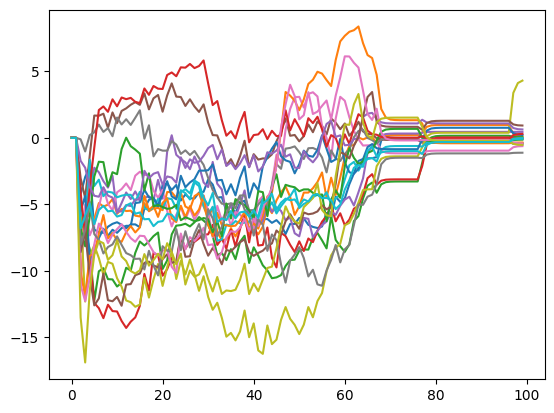

In [17]:
_ = plt.plot( out_v_mem[1] )

# Small Hyperparameter Tuning / Early Analysis
---


In [9]:
### Tau FF: Hidden
args.train_alpha = False
args.hierarchy_tau = False
args.distrib_tau = False
args.recurrent = False
# network architecture
if args.recurrent: model = hrsnn_step
else: model = hsnn_step
args.n_layers = 3
args.n_hid = 128
# time constants
args.tau_mem = 0.1 #0.1
args.tau_out = 0.01
# weight init
### 0.3 for FF, 0.1 for Rec
if args.recurrent: args.w_scale = 0.1
else : args.w_scale = 0.3
# LR and regularizers
args.lr = 0.01
args.lr_decay = 0.5
args.lr_decay_every = 50
args.l2_lambda = 5e-5
args.freq_lambda = 5e-5
args.dropout_rate = 0.1
n_epochs = 50

tau_list = [0.001, 0.01, 0.05, 0.1, 0.25]
test_acc_shd_list, val_acc_shd_list = [], []
for t, tau in enumerate( tau_list ):
    args.tau_mem = tau
    print(f'-- Tau = {tau*1e3}ms')
    _, test_acc_shd, test_acc_ssc, val_acc_shd, _ = train_mosaic(key = jax.random.PRNGKey(args.seed), n_batch=args.batch_size, n_epochs=n_epochs, args = args, lr = args.lr, 
                                    train_dl = train_loader_custom_collate, test_dl = test_loader_custom_collate, val_dl=val_loader_custom_collate,
                                    model=model, param_initializer=params_initializer, decoder=decoder_sum,
                                    noise_start_step=10, noise_std=0.1, dataset_name='shd', verbose=False)
    test_acc_shd_list.append( test_acc_shd ), val_acc_shd_list.append( val_acc_shd )
    

Tau = 1.0ms
SHD Validation Accuracy: 65.38
SHD Test Accuracy: 56.85
Tau = 10.0ms
SHD Validation Accuracy: 69.98
SHD Test Accuracy: 60.78
Tau = 50.0ms
SHD Validation Accuracy: 77.94
SHD Test Accuracy: 57.86
Tau = 100.0ms
SHD Validation Accuracy: 81.50
SHD Test Accuracy: 65.24
Tau = 250.0ms
SHD Validation Accuracy: 85.42
SHD Test Accuracy: 68.11


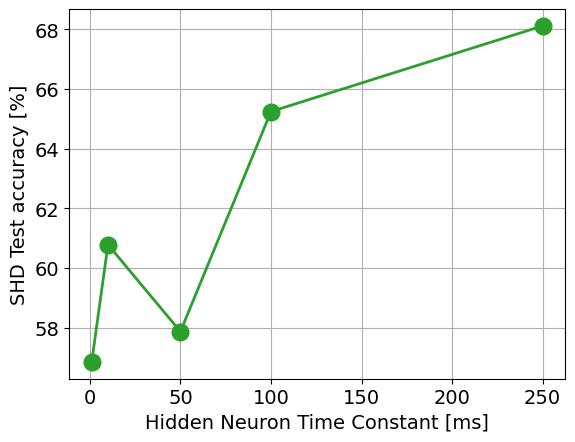

In [16]:
fig, ax = plt.subplots()
tau_list = [0.001, 0.01, 0.05, 0.1, 0.25]
ax.plot( np.array(tau_list)*1e3, test_acc_shd_list, marker='o', color='tab:green', lw=2, markersize=12 )
ax.set_xlabel( 'Hidden Neuron Time Constant [ms]', size=14 )
ax.set_ylabel( 'SHD Test accuracy [%]', size=14 )
ax.tick_params( labelsize=14 )
ax.grid(True)

In [17]:
### Tau FF: output
args.train_alpha = False
args.hierarchy_tau = False
args.distrib_tau = False
args.recurrent = False
# network architecture
if args.recurrent: model = hrsnn_step
else: model = hsnn_step
args.n_layers = 3
args.n_hid = 128
# time constants
args.tau_mem = 0.25 #0.1
args.tau_out = 0.01
# weight init
### 0.3 for FF, 0.1 for Rec
if args.recurrent: args.w_scale = 0.1
else : args.w_scale = 0.3
# LR and regularizers
args.lr = 0.01
args.lr_decay = 0.5
args.lr_decay_every = 50
args.l2_lambda = 5e-5
args.freq_lambda = 5e-5
args.dropout_rate = 0.1
n_epochs = 50

tau_list = [0.001, 0.01, 0.05, 0.1, 0.25]
test_acc_shd_list, val_acc_shd_list = [], []
for t, tau in enumerate( tau_list ):
    args.tau_out = tau
    print(f'-- Tau = {tau*1e3}ms')
    _, test_acc_shd, test_acc_ssc, val_acc_shd, _ = train_mosaic(key = jax.random.PRNGKey(args.seed), n_batch=args.batch_size, n_epochs=n_epochs, args = args, lr = args.lr, 
                                    train_dl = train_loader_custom_collate, test_dl = test_loader_custom_collate, val_dl=val_loader_custom_collate,
                                    model=model, param_initializer=params_initializer, decoder=decoder_sum,
                                    noise_start_step=10, noise_std=0.1, dataset_name='shd', verbose=False)
    test_acc_shd_list.append( test_acc_shd ), val_acc_shd_list.append( val_acc_shd )
    

-- Tau = 1.0ms
SHD Validation Accuracy: 85.85
SHD Test Accuracy: 68.15
-- Tau = 10.0ms
SHD Validation Accuracy: 84.01
SHD Test Accuracy: 70.67
-- Tau = 50.0ms
SHD Validation Accuracy: 83.33
SHD Test Accuracy: 64.58
-- Tau = 100.0ms
SHD Validation Accuracy: 68.69
SHD Test Accuracy: 60.69
-- Tau = 250.0ms
SHD Validation Accuracy: 38.42
SHD Test Accuracy: 35.78


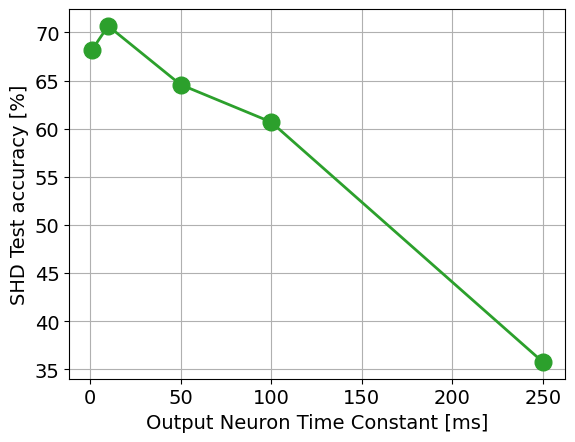

In [18]:
fig, ax = plt.subplots()
tau_list = [0.001, 0.01, 0.05, 0.1, 0.25]
ax.plot( np.array(tau_list)*1e3, test_acc_shd_list, marker='o', color='tab:green', lw=2, markersize=12 )
ax.set_xlabel( 'Output Neuron Time Constant [ms]', size=14 )
ax.set_ylabel( 'SHD Test accuracy [%]', size=14 )
ax.tick_params( labelsize=14 )
ax.grid(True)